# Korrekt Hest Batteri Stempel

Målet for denne notesbog er at udlede en liste af ord der er velegnet til brug i [XKCD-style kodesætninger][xkcd936].

Herfor er kriterierne at:

- ordene skal være nemme at huske,
- ordene skal være nemme at stave, og
- ordlisten skal være lang, så antallet a mulige permutationer er stor.

Jeg tror, at jeg kan opnå det ved hjælp af følgende kilder:

1. [DSLs frekvensordbog](https://korpus.dsl.dk/resources/details/freq-lemmas.html)
2. [DSLs liste af ofte misstavede ord](https://korpus.dsl.dk/resources/details/ddo-misspellings.html)

[xkcd936]: https://www.explainxkcd.com/wiki/index.php/936:_Password_Strength

## Indlæse data

Første trin er sevlfølgelig at indlæse vores ordlister. Begge er CSV-filer der findes i de vedlage Zip-filer inden i `data/`. Derfor kan vi lige starte med at importere de relevante moduler.


In [90]:
import zipfile
import csv
import io
import collections

Vi kommer desuden til at så på en række ret store datastrukture,
så jeg definerer også lige en funktion til at fremvise resultatet.
Det overrasker mig, at det ikke allerede er indbygget.
Det må næsten være mig der har misset den funktionalitet et eller andet sted.

In [ ]:
from IPython.display import HTML
from pprint import pformat

def truncate(data, *, max_height_px = 300):
	return HTML(f"""
			 <div style="max-height: {max_height_px}px; overflow: auto; border: 1px solid #eee; font-family: monospace">
			 	<pre>{pformat(data)}</pre>
			 </div>
	 """)

### Frekvensordbogen



Lad os nu først indlæse frekvensordbogen. Den findes i en zipfil i [`data/freq-lemma.zip`](./data/freq-lemma.zip) og indeholder to filer:

> Listen findes i to varianter, som er pakket sammen i en zip-fil:
> 
> 1. De 30.000 mest frekvente lemmaer (ord) i dansk inklusive proprier (egennavne) og numeralier (talord)
> 2. De 30.000 mest frekvente lemmaer i dansk eksklusive proprier og numeralier.

Lidt arbitrært vælger jeg at vi _ikke_ vil have proprier med. Altså skal vi have fat i `freq-30k-ex.txt` inde i Zip-filen.
Yderligere står der:

> Listerne er i rent tekstformat med LF-linjeskift, som bruges i Unix, Linux og MacOS. Dette kan forårsage formateringsproblemer i Windows-baserede programmer. Problemerne kan løses ved at åbne listen i en teksteditor og gemme den igen under et nyt navn.
> 
> [...]
> 
> Oplysningstyperne er separeret med TAB (tabulator). Herunder ses de første 10 linjer af listen uden egennavne og talord.

Den information kan vi videregive til `csv.reader` så den fortolker filen korrekt.

In [92]:
with zipfile.ZipFile("data/freq-lemma.zip") as zf:
	with io.TextIOWrapper(zf.open("freq-30k-ex.txt"), newline="\n") as fp:
		reader = csv.reader(fp, delimiter="\t", lineterminator="\n")
		raw_frequency_data = list(reader)
	
print(f"Indlæste {len(raw_frequency_data)} lemmaer")
truncate(raw_frequency_data)

Indlæste 30000 lemmaer


Hver række i tabellen indeholder tre værdier.
Ifølge dokumentationen er deres betydning som føgler:

> Hver linje i listen indeholder tre oplysningstyper:
>
> 1. Lemmaets ordklasse (POS)
> 2. Lemmaformen
> 3. Lemmaets frekvens summeret for samtlige af dets bøjningsformer.

Indledningsvist kan vi lige ændre række-typen til en `namedtuple`, for de er lidt nemmere at arbejde med end numeriske indekse.

In [93]:
FrequencyLemma = collections.namedtuple("FrequencyLemma", ("pos", "lemma", "frequency"))
frequency_data = map(lambda row: FrequencyLemma(row[0], row[1], float(row[2])), raw_frequency_data)


Senere i dokumentationen uddybes betydningen af det første felt.
De giver følgende tabel:

<!-- Denne tabel kan ikke være i en blokcitation, for så renderes den ikke -->
|  Tag  |  POS             |  Example      |
|-------|------------------|---------------|
|  A    |  adjective       |  god          |
|  C    |  conjunction     |  og           |
|  D    |  adverb          |  ud           |
|  EW   |  POW lex.item    |  anti@        |
|  I    |  interjection    |  ja           |
|  L    |  numeral         |  13           |
|  LW   |  POW numeral     |  10           |
|  M    |  POW morph.item  |  @erne        |
|  NC   |  common noun     |  år           |
|  NP   |  proper noun     |  Danmark      |
|  NW   |  POW noun        |  tv           |
|  P    |  pronoun         |  den          |
|  T    |  preposition     |  i            |
|  U    |  "unique"        |  at, som, der |
|  V    |  verb            |  være         |


Vi filtrerer lige nogle ordklasser fra, som ikke er velegnede til at indgå i kodesætninger.
Det inkluderer bl.a. morfemer, der ikke kan stå for sig selv (kendetegnet ved `M`).

In [94]:
BANNED_POS = {"EW", "LW", "M", "NP", "U"}
frequency_data = filter(lambda row: row.pos not in BANNED_POS, frequency_data)

Lad os se hvad vi er endt med.
Bemærk at dataene allerede er sorteret efter frekvens!

In [95]:

frequency_data = list(frequency_data)
truncate(frequency_data)

### Typiske stavefejl

Lad os nu vende blikket mod [`data/ddo-misspellings.zip`](data/ddo-misspellings.zip).
Processen her er stort set den samme som i ovenstående afsnit.

Den relevante dokumentation er dejlig kort i dette tilfælde:

> Listen er TAB-separeret og rummer to felter: fejlform (bøjningsform eller opslagsform) og korrekt opslagsform.

Igen benyttes en `namedtuple` for at gøre dataene nemmere at arbejde med.
Denne gang er gør vi det bare uden den midlertidige liste.

In [96]:
Misspelling = collections.namedtuple("Misspelling", ("wrong", "correct"))

with zipfile.ZipFile("data/ddo-misspellings.zip") as zf:
	with io.TextIOWrapper(zf.open("ddo_misspellings_2020-08-26.csv"), newline="\n") as fp:
		reader = csv.reader(fp, delimiter="\t", lineterminator="\n")
		misspellings_data = list(map(Misspelling._make, reader))

print(f"Indlæste {len(misspellings_data)} typiske stavefejl")
truncate(misspellings_data)

Indlæste 16619 typiske stavefejl


## Beregn ordliste

Så kommer den spændende del!
Min strategi er såresimpel:
tag udgangspunkt i listen af hyppigste ord, men frasortér alle ord,
der ofte staves forkert.

I den henseende har vi faktisk ikke brug for helt så meget data ud fra de tabeller vi læste.
Vi kan nøjes med to sæt:
mængden af ord, der typisk staves forkert og
mængden af de mest hyppigt fremkonme danske ord.

In [97]:
commonly_misspelled = set(row.correct for row in misspellings_data)
lemmas = set(row.lemma for row in frequency_data)

Når dataene står på denne form bliver det trivielt at se hvilke hyppige ord der typisk staves forkert. Det er nemlig netop fællesmængden af de to mængder.

In [98]:
frequent_and_commonly_misspelled = lemmas.intersection(commonly_misspelled)
print(f"{len(frequent_and_commonly_misspelled)} af de {len(lemmas)} mest hyppige ord staves ofte forkert")

944 af de 29143 mest hyppige ord staves ofte forkert


Nu er det trivielt at finde frem til vores ordliste.
Det er nemlig netop de lemmaer der ikke er medlem af mænden af mest hyppige stavefejl.
Nogle gange forstår jeg virkelig godt hvad folk mener, når de siger at "Python er eksekverbar pseudokode."

In [ ]:
word_list = lemmas - commonly_misspelled
truncate(word_list)

Men jeg vil faktisk gerne have en version,
der bevarer sorteringen efter frekvens
(det skal vi nemlig bruge senere),
hvilket `set`-datastrukturen ikke garanterer.

In [ ]:
word_list = [row.lemma for row in frequency_data if row.lemma not in frequent_and_commonly_misspelled]
truncate(word_list)

## Beregn entropi

Men hvor mange ord er der så tilbage?
Det hjælper jo lige godt,
hvis den ordliste vi har generet kun indeholder ti ord.
Hvor mange ord har vi brug for?

Vi kan overbevise os selv om
at vores kodesætninger kommer til at være sikre
ved at undersøge hvor meget entropi vi får.
Denne kan beregnes ved formlen

$$E = log_2(n^L)$$

for $n$ angiver længden af ordlisten og $L$ angiver antallet af ord i kodesætningen.
Det kan vi nemt omformulere til Python, og beregne et par forskellige værdier.

In [ ]:
import numpy as np

def E(n, L):
	"""Calculate the entropy for a given dictionary size `n` and passphrase length `L`"""
	return np.log2(n ** L)

Men entropien er lidt svær at forholde sig til.
Jeg ville være mere tryg,
hvis jeg vidste,
hvor mange år det ville tage en dedikeret hacker at cracke mit password,
ligesom Randall beregner i den original XKCD.

Moores Lov har selvfølgelig ikke stået på pause siden 2011,
så jeg har sat `GUESSES_PER_SECOND` baseret på [en Stackoverflow-tråd fra 2019](https://stackoverflow.com/a/54735613).
Her antages det, at kodeordene gemmes med et bcrypt;
et meget stærk hash.

In [ ]:
def secnds_to_crack(E):
	GUESSES_PER_SECOND = 28_000
	seconds = 2**E / GUESSES_PER_SECOND
	return seconds

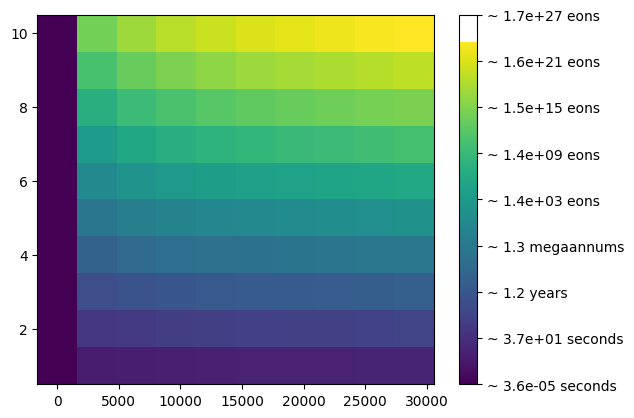

In [ ]:
from matplotlib import pyplot as plt

def format_seconds(seconds):
	SECONDS_PER_YEAR = 365.2425 * 24 * 60 * 60
	UNITS = [("eons", 10**9 * SECONDS_PER_YEAR),
	         ("megaannums", 10**6 * SECONDS_PER_YEAR),
	         ("terasecond", 10**12),
	         ("millennia", 1000 * SECONDS_PER_YEAR),
	         ("years", SECONDS_PER_YEAR),
	         ("days", 24 * 60 * 60),
	         ("hours", 60 * 60),
	         ("minutes", 60)]
	for unit_name, seconds_per_unit in UNITS:
		if seconds_per_unit <= seconds:
			return f"~ {seconds/seconds_per_unit:.2} {unit_name}"
	else:
		return f"~ {seconds:.2} seconds"

ns, Ls = np.meshgrid(np.linspace(1, len(word_list), num=10),
					 np.linspace(1, 10, num=10))
Es = E(ns, Ls)

plt.pcolormesh(ns, Ls, Es)
cbar = plt.colorbar()
ticks = cbar.get_ticks()
cbar.set_ticks(ticks, labels=map(lambda E: format_seconds(secnds_to_crack(E)), ticks))


Wow det er pænt godt!
Husk på at dette er tiden det vil tage at cracke ét enkelt kodeord,
da de fleste moderne hash-schemes benytter [salte](https://sv.wikipedia.org/wiki/Salt_(kryptografi)).

Jeg holder mig generelt til kodesætninger på 5 ord,
så baseret på ovenstående graf er jeg komfortabel med
at benytte en ordliste på $15.000$ ord.
Jo kortere ordlisten er, jo mindre er chancen for
at en kodesætning kommer til at indeholde et ord,
som jeg ikke kender.

Eftersom vi bevarede sorteringen efter frekvens ovenfor
kan vi vælge de $n$ mest hyppige ord med et simpelt slice.

In [ ]:
truncated_word_list = word_list[:15_000]

Vi kan lige skrive den ud til en fil som kan gives til `xkcdpass`, og så er vi sådan set færdige.

In [ ]:
with open("words.txt", mode="wt") as fp:
	fp.write("\n".join(truncated_word_list))